In [126]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
from io import open
import glob
import os
import random


In [127]:
def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
Slusarski


In [128]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [129]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for idx, letter in enumerate(line):
        tensor[idx][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [130]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [131]:
input = letterToTensor('A')
print('input', input.shape)
hidden = torch.zeros(1, n_hidden)
print('init_hidden', hidden.shape)

output, next_hidden = rnn(input, hidden)

print('output', input.shape)
print('output hidden', next_hidden.shape)


input torch.Size([1, 57])
init_hidden torch.Size([1, 128])
output torch.Size([1, 57])
output hidden torch.Size([1, 128])


In [132]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
print('input', input.shape)

print('output', output.shape)
print('output hidden', next_hidden.shape)

input torch.Size([6, 1, 57])
output torch.Size([1, 18])
output hidden torch.Size([1, 128])


In [133]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Korean', 16)


In [134]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Russian / line = Abzhalilov
category = German / line = Gunther
category = Japanese / line = Nogushi
category = English / line = Miles
category = Vietnamese / line = Vuong
category = Irish / line = Niadh
category = Japanese / line = Kanada
category = Dutch / line = Severins
category = Arabic / line = Nassar
category = Russian / line = Mischuk


In [135]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.0005)

In [136]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()
    # optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    # optimizer.step()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()


In [137]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 2% (0m 2s) 2.8380 Dirchs / Arabic ✗ (German)
10000 5% (0m 4s) 1.0090 Yap / Chinese ✓
15000 7% (0m 6s) 3.0029 Halliwell / Scottish ✗ (English)
20000 10% (0m 8s) 2.4548 Abel / German ✗ (Spanish)
25000 12% (0m 11s) 1.6547 Rusnak / Czech ✗ (Polish)
30000 15% (0m 13s) 0.4833 Malouf / Arabic ✓
35000 17% (0m 15s) 1.2894 Fabre / French ✓
40000 20% (0m 17s) 0.3624 Lawniczak / Polish ✓
45000 22% (0m 19s) 0.6823 Boehler / German ✓
50000 25% (0m 22s) 1.2694 San / Chinese ✗ (Korean)
55000 27% (0m 24s) 1.1068 Hiu / Chinese ✓
60000 30% (0m 26s) 2.7176 Hout / Arabic ✗ (Dutch)
65000 32% (0m 28s) 2.6902 Lucas / Greek ✗ (Dutch)
70000 35% (0m 30s) 2.9677 Sastre / Arabic ✗ (Spanish)
75000 37% (0m 33s) 0.0901 Jupikov / Russian ✓
80000 40% (0m 35s) 1.4423 San / Chinese ✗ (Korean)
85000 42% (0m 37s) 1.8337 Abel / Spanish ✓
90000 45% (0m 39s) 0.5429 Cvacek / Czech ✓
95000 47% (0m 42s) 0.7006 Basurto / Portuguese ✓
100000 50% (0m 44s) 0.4495 Suk / Korean ✓
105000 52% (0m 46s) 1.9308 Abel / Czech ✗ (German)

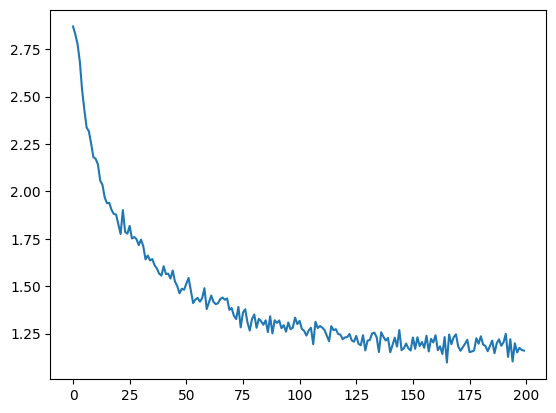

In [138]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)